# SceneBERT
# English USE/BERT Model for Scene Change Detection

In [1]:
import os
os.environ['TF_USE_LEGACY_KERAS']='1'

### Read in and prepare the data.

In [8]:
import pandas as pd
import os

def read_xlsx_files_from_folder(folder_path):
    """Reads all .xlsx files from the given folder and returns a list of DataFrames."""
    all_dfs = []  # List to store DataFrames
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xlsx"):  # Process only .xlsx files
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)
            all_dfs.append(df)  # Append the DataFrame to the list
            print(f"Loaded: {file_name}")
    return all_dfs

# Example usage on 6 sentence segments
folder_path = '/Users/.../6_sentences_segmented_combined_TrainingSet'  # Replace with your folder path

# Read all Excel files from the folder
dfs = read_xlsx_files_from_folder(folder_path)

# Optionally, combine all DataFrames into a single one (if desired)
df_scene6 = pd.concat(dfs, ignore_index=True)



Loaded: 9783838713625.txt_segments.xlsx
Loaded: Warriors_Embrace_MISSISSIPPI.txt_segments.xlsx
Loaded: Pros_and_Cons_MASSACHUSETTS.txt_segments.xlsx
Loaded: 9783732596881.txt_segments.xlsx
Loaded: 9783732586875.txt_segments.xlsx
Loaded: 9783732596249.txt_segments.xlsx
Loaded: Love_by_Proxy_ILLINOIS.txt_segments.xlsx
Loaded: 9783732557905.txt_segments.xlsx
Loaded: Tangled_Lies_HAWAII.txt_segments.xlsx
Loaded: 9783732591725.txt_segments.xlsx
Loaded: 9783838721675.txt_segments.xlsx
Loaded: Midnight_Wishes_WYOMING.txt_segments.xlsx
Loaded: 9783732584017.txt_segments.xlsx
Loaded: 9783732597314.txt_segments.xlsx
Loaded: Cowboy_Be_Mine_TEXAS.txt_segments.xlsx
Loaded: Too_Near_the_Fire_OHIO.txt_segments.xlsx
Loaded: 9783732502929.txt_segments.xlsx
Loaded: Deceptions_CALIFORNIA_SG.txt_segments.xlsx
Loaded: 9783732522033.txt_segments.xlsx
Loaded: 9783740941093.txt_segments.xlsx
Loaded: 9783740965716.txt_segments.xlsx
Loaded: Found_his_perfect_wife_ALASKA_SG.txt_segments.xlsx
Loaded: 978373251769

In [9]:
#look at the top of the table
df_scene6

,Segment,scene-change
0,"Ah Ahaual, ruler of the Mayan city of Ah Kin P...",yes
1,He cleared away the obstacles and uncovered th...,yes
2,The darkness receded before the flickering glo...,no
3,Then he pulled the torch head back enough to b...,no
4,"The Sky Stone. To Ts'onot, the ""White God"" had...",no
...,...,...
17099,Luis had had a long telephone conversation wit...,yes
17100,And they now had something to rack their brain...,no
17101,"""Time will tell,"" Mrs. Rennert agreed. ""But be...",no
17102,"""Well, let's see what the future holds for us,...",no


In [10]:
df_scene6.describe()

,Segment,scene-change
count,17104,17104
unique,17104,2
top,"Ah Ahaual, ruler of the Mayan city of Ah Kin P...",no
freq,1,13431


In [11]:
#translate text labels to numeric
df_scene6['Labels']=df_scene6['scene-change'].map({'no': 0, 'yes':1})
#drop the "Tag" column
df_scene=df_scene6.drop(["scene-change"], axis=1)

In [12]:
#import libraries etc
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [13]:
#define number of classes (more important if you have multiple)
num_classes = len(df_scene["Labels"].value_counts())

### Load the model

In [14]:
#load tensorflow and data division
#!pip install tensorflow #if needed
#!pip install --upgrade tensorflow tensorflow-hub tensorflow-text

#!pip install tensorflow_text
#import tensorflow_text as text  # Registers the ops.


#load tensorflow and data division
import tensorflow as tf
from sklearn.model_selection import train_test_split

In [16]:
#turn numeric labels into categorical variables
y=tf.keras.utils.to_categorical(df_scene["Labels"].values, num_classes=num_classes)
#split sample into training and test sets
x_train, x_test, y_train, y_test=train_test_split(df_scene['Segment'], y, test_size=0.25)

In [17]:
#import Bert Models
import tensorflow_hub as hub
import tensorflow_text as text

#create preprocessor and encoder/bert models
#preprocessor = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')
#encoder = hub.load('https://tfhub.dev/google/experts/bert/answerdotai/ModernBERT-base')

#define the preprocessor and encoder - use the multilingual "universal-sentence cmlm 
#see: https://www.tensorflow.org/hub/tutorials/senteval_for_universal_sentence_encoder_cmlm
preprocessor = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-preprocess/2")
encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-cmlm/multilingual-base/1")

#in case of a Value Error message, try "rm -rf /var/folders/0l/jmlpg6g91sd3fl4ry6lcl8lw0000gn/T/tfhub_modules/" in your terminal

2025-03-14 12:34:21.135747: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-03-14 12:34:21.135782: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-03-14 12:34:21.135789: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
I0000 00:00:1741952061.135806 20773240 pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
I0000 00:00:1741952061.135825 20773240 pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2025-03-14 12:34:21.776568: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


In [19]:
#create model parameters
i = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
x = preprocessor(i)
x = encoder(x)
x = tf.keras.layers.Dropout(0.2, name="dropout")(x['pooled_output'])
x = tf.keras.layers.Dense(num_classes, activation='softmax', name="output")(x)
model_scene = tf.keras.Model(i, x)

In [20]:
#create functions for evaluating the model
import tensorflow.keras.backend as K

def balanced_recall(y_true, y_pred):
	"""This function calculates the balanced recall metric recall = TP /(TP+FN)"""
	recall_by_class=0
	for i in range(y_pred.shape[1]):
		y_pred_class=y_pred[:, i]
		y_true_class=y_true[:, i]
		true_positives=K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
		possible_positives=K.sum(K.round(K.clip(y_true_class, 0, 1)))
		recall = true_positives / (possible_positives +K.epsilon())
		recall_by_class = recall_by_class + recall
	return recall_by_class / y_pred.shape[1]

def balanced_precision(y_true, y_pred):
	"""This function calculates the balanced precision metric precision = TP / (TP+FP)"""
	precision_by_class=0
	for i in range(y_pred.shape[1]):
		y_pred_class = y_pred[:, i]
		y_true_class = y_true[:, i]
		true_positives = K.sum(K.round(K.clip(y_true_class * y_pred_class, 0, 1)))
		predicted_positives = K.sum(K.round(K.clip(y_pred_class, 0, 1)))
		precision = true_positives / (predicted_positives + K.epsilon())
		precision_by_class = precision_by_class + precision
	return precision_by_class / y_pred.shape[1]


def balanced_f1_score(y_true, y_pred):
	"""This function calculates the F1 score metric"""
	precision = balanced_precision(y_true, y_pred)
	recall = balanced_recall(y_true, y_pred)
	return 2 * ((precision * recall) / (precision + recall + K.epsilon()))

In [21]:
#new results from 2025-01-31 with 7 training texts
#run the model - this is an alternative cell for showcasing a run with 10 epochs only

n_epochs = 15#20
METRICS = [ tf.keras.metrics.CategoricalAccuracy(name="accuracy"), balanced_recall, balanced_precision, balanced_f1_score]

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3, restore_best_weights = True)

model_scene.compile(optimizer = "adam", loss = "categorical_crossentropy",metrics = METRICS)

model_scene_fit = model_scene.fit(x_train, y_train, epochs = n_epochs, validation_data = (x_test, y_test), callbacks = [earlystop_callback])

Epoch 1/15
401/401 [==============================] - 1262s 3s/step - loss: 0.4698 - accuracy: 0.7859 - balanced_recall: 0.5511 - balanced_precision: 0.5856 - balanced_f1_score: 0.5594 - val_loss: 0.4358 - val_accuracy: 0.8047 - val_balanced_recall: 0.6238 - val_balanced_precision: 0.7030 - val_balanced_f1_score: 0.6583
Epoch 2/15
401/401 [==============================] - 1210s 3s/step - loss: 0.4417 - accuracy: 0.7933 - balanced_recall: 0.5862 - balanced_precision: 0.6590 - balanced_f1_score: 0.6144 - val_loss: 0.4233 - val_accuracy: 0.8099 - val_balanced_recall: 0.6069 - val_balanced_precision: 0.7107 - val_balanced_f1_score: 0.6506
Epoch 3/15
401/401 [==============================] - 1156s 3s/step - loss: 0.4329 - accuracy: 0.8019 - balanced_recall: 0.6037 - balanced_precision: 0.6898 - balanced_f1_score: 0.6386 - val_loss: 0.4255 - val_accuracy: 0.8057 - val_balanced_recall: 0.5825 - val_balanced_precision: 0.6920 - val_balanced_f1_score: 0.6261
Epoch 4/15
401/401 [==============

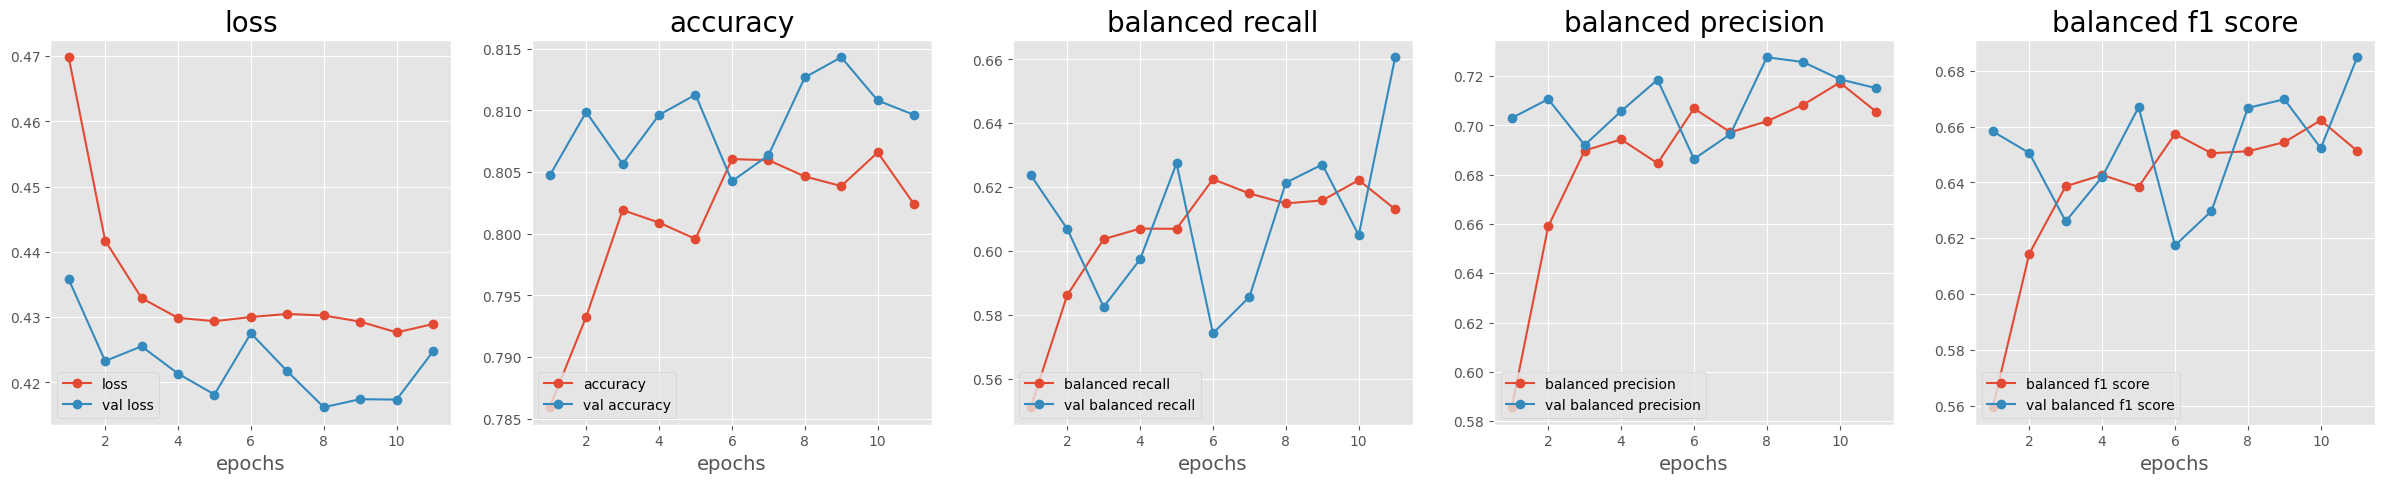

In [23]:
#plot change in accuracy scores over epochs
x = list(range(1, 11+1)) # second number must be changed to the actual number of trained epochs for visualization
metric_list = list(model_scene_fit.history.keys())
num_metrics = int(len(metric_list)/2)

fig, ax = plt.subplots(nrows=1, ncols=num_metrics, figsize=(30, 5))

for i in range(0, num_metrics):
    ax[i].plot(x, model_scene_fit.history[metric_list[i]], marker="o", label=metric_list[i].replace("_", " "))
    ax[i].plot(x, model_scene_fit.history[metric_list[i+num_metrics]], marker="o", label=metric_list[i+num_metrics].replace("_", " "))
    ax[i].set_xlabel("epochs",fontsize=14)
    ax[i].set_title(metric_list[i].replace("_", " "),fontsize=20)
    ax[i].legend(loc="lower left")
    #ax[i].set_ylim([0,1])
    
fig.savefig('/Users//Users/.../20250314_ClassificationSuccess_SceneChangeDetection_6_Segments.pdf')


In [84]:
model_scene.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text (InputLayer)           [(None,)]                    0         []                            
                                                                                                  
 keras_layer (KerasLayer)    {'input_word_ids': (None,    0         ['text[0][0]']                
                             128),                                                                
                              'input_mask': (None, 128)                                           
                             , 'input_type_ids': (None,                                           
                              128)}                                                               
                                                                                              

### Save and reload the model
Doesn't work for now! But the prediction does work.

In [24]:
#save the model for future use
model_scene.save("/Users//Users/.../20250314SceneChangeModel6.keras")


In [1]:
# Load the model from the saved file
reloaded_scene_change_detector_model = tf.keras.models.load_model("/Users//Users/.../20250314SceneChangeModel6.keras")#, custom_objects={"CustomRNN": CustomRNN})

## Functions for Evaluating the model on a separate test set

In [25]:
#function for predicting new 6-sentence passage with scene change detector
def predict_class(reviews):
  return [np.argmax(pred) for pred in model_scene.predict(reviews)]

In [26]:
import pandas as pd
import os

def read_xlsx_files_from_folder(folder_path):
    """Reads all .xlsx files from the given folder and returns a list of DataFrames."""
    all_dfs = []  # List to store DataFrames
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".xlsx"):  # Process only .xlsx files
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_excel(file_path)
            all_dfs.append(df)  # Append the DataFrame to the list
            print(f"Loaded: {file_name}")
    return all_dfs

# Load the test set (50 scene annotations; set contains the last 5 scenes of each of the 10 Men Made in America Romance novels)
folder_path = '/Users//Users/.../segmented_6_sentences_TestSet'
# Read all Excel files from the folder
dfs = read_xlsx_files_from_folder(folder_path)

# Optionally, combine all DataFrames into a single one (if desired)
test_scene_text = pd.concat(dfs, ignore_index=True)



Loaded: Test_Set_5_Last_Scenes.txt_segments.xlsx


In [27]:
#look at the top of the table
test_scene_text

,Segment,scene-change
0,Steve wore a path in the rug at the Algonquin ...,yes
1,How could he leave New York when\nAngel was he...,yes
2,"""\nWas he that bad? Steve wondered. Probably. ...",no
3,There was only one thing for Steve to do: Get ...,no
4,Before you do I want to say one thing. I since...,no
...,...,...
488,Somehow she never got around to opening a sepa...,no
489,They installed a gate between the two houses s...,yes
490,"""A boy and a girl,"" Michael told her with prid...",yes
491,"""What can I say?"" he told her, his eyes alight...",no


In [3]:
#extract the segments without the gold annotations
test_scene_detection = test_scene_text['Segment'].tolist()
#test_scene_detection

In [29]:
#run the model and predict the probability of a scene-change happening in a 6-sentence segment
perc_probability=model_scene.predict(test_scene_detection)

16/16 [==============================] - 38s 2s/step


In [30]:
#store the predicted probabilities in the new columns and concatenate it with the original dataframe containing the text segments and the gold annotations
prob_df = pd.DataFrame(perc_probability, columns=['no', 'yes'])
combined_table=pd.concat([test_scene_text, prob_df], axis=1)

In [31]:
#show the combined table
combined_table

,Segment,scene-change,no,yes
0,Steve wore a path in the rug at the Algonquin ...,yes,0.397421,0.602579
1,How could he leave New York when\nAngel was he...,yes,0.974085,0.025915
2,"""\nWas he that bad? Steve wondered. Probably. ...",no,0.889961,0.110039
3,There was only one thing for Steve to do: Get ...,no,0.547380,0.452620
4,Before you do I want to say one thing. I since...,no,0.978704,0.021296
...,...,...,...,...
488,Somehow she never got around to opening a sepa...,no,0.270998,0.729002
489,They installed a gate between the two houses s...,yes,0.396577,0.603423
490,"""A boy and a girl,"" Michael told her with prid...",yes,0.936660,0.063340
491,"""What can I say?"" he told her, his eyes alight...",no,0.895859,0.104141


In [32]:
#Save the predictions of the test set to a combined table with the manual annotations
combined_table.to_csv(r'/Users//Users/.../Prediction_results/20250314_TestSet6_Predictions.csv')

## Start of the evaluation of the predictions

In [33]:
import pandas as pd
from sklearn.metrics import confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
# load data with pseudo predictions (true values and predictions)
# attention: chose the right separator! ';' or ','
predictions = pd.read_csv('/Users//Users/.../Prediction_results/20250314_TestSet6_Predictions.csv', sep=",", encoding="utf-8", index_col=0)

predictions.rename(columns={'scene-change': 'true_values'}, inplace=True)

predictions.head()


,Segment,true_values,no,yes
0,Steve wore a path in the rug at the Algonquin ...,yes,0.397421,0.602579
1,How could he leave New York when\nAngel was he...,yes,0.974085,0.025915
2,"""\nWas he that bad? Steve wondered. Probably. ...",no,0.889961,0.110039
3,There was only one thing for Steve to do: Get ...,no,0.547380,0.452620
4,Before you do I want to say one thing. I since...,no,0.978704,0.021296


In [77]:
# convert the true values from "yes" and "no" to binary
predictions['y_true'] = predictions['true_values'].apply(lambda x: 1 if x == "yes" else 0)

# Define a threshold for the predictions. Start with: 0.5
threshold = 0.36 #decision threshold
predictions['y_pred'] = predictions['yes'].apply(lambda x: 1 if x >= threshold else 0)

In [78]:
#show predictions
predictions

,Segment,true_values,no,yes,y_true,y_pred
0,Steve wore a path in the rug at the Algonquin ...,yes,0.397421,0.602579,1,1
1,How could he leave New York when\nAngel was he...,yes,0.974085,0.025915,1,0
2,"""\nWas he that bad? Steve wondered. Probably. ...",no,0.889961,0.110039,0,0
3,There was only one thing for Steve to do: Get ...,no,0.547380,0.452620,0,1
4,Before you do I want to say one thing. I since...,no,0.978704,0.021296,0,0
...,...,...,...,...,...,...
488,Somehow she never got around to opening a sepa...,no,0.270998,0.729002,0,1
489,They installed a gate between the two houses s...,yes,0.396577,0.603423,1,1
490,"""A boy and a girl,"" Michael told her with prid...",yes,0.936660,0.063340,1,0
491,"""What can I say?"" he told her, his eyes alight...",no,0.895859,0.104141,0,0


In [79]:
y_true = predictions['y_true']
y_pred = predictions['y_pred']
y_scores = predictions['yes']

# Calculation of Evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
roc_auc = roc_auc_score(y_true, y_scores)
conf_matrix = confusion_matrix(y_true, y_pred)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1 Score: ", f1)
print("ROC AUC: ", roc_auc)
print("Confusion Matrix: \n", conf_matrix)

Accuracy:  0.8336713995943205
Precision:  0.5857142857142857
Recall:  0.43617021276595747
F1 Score:  0.5
ROC AUC:  0.7745694022289766
Confusion Matrix: 
 [[370  29]
 [ 53  41]]


Confusion Matrix: 
 [[370  29]
 [ 53  41]]


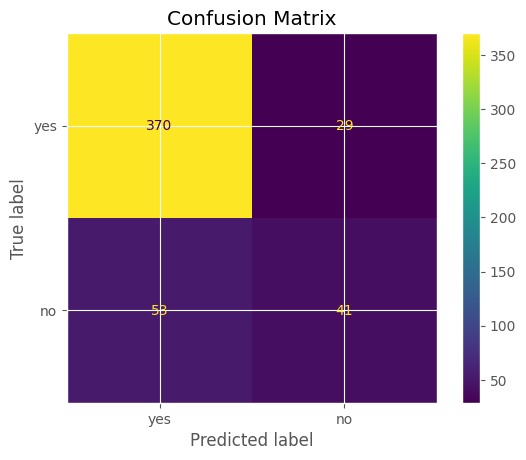

In [80]:
# Confusion Matrix
# Calculation of Evaluation metrics
conf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix: \n", conf_matrix)

# Shows the Confusion Matrix:
ConfusionMatrixDisplay(conf_matrix, display_labels=["yes", "no"]).plot()
plt.title('Confusion Matrix')
plt.show()

## Use the model for the prediction of new data.

In [38]:
#function for predicting new 6-sentence passage with scene change detector
def predict_class(reviews):
  return [np.argmax(pred) for pred in model_scene.predict(reviews)]

In [5]:
#read in unseen data for prediction

raw_data = pd.read_excel('/Users//Users/.../for_prediction/xxxx.xlsx')


In [ ]:
#extract the text segments for prediction and run the model for the prediction
prediction_scene_text = raw_data['Segment'].tolist()
scene_perc_probability=model_scene.predict(prediction_scene_text)

In [ ]:
#store the predicted probabilities in the new columns and concatenate it with the original dataframe containing the text segments and the default "no" annotations which is to be overwritten 

scene_prob_df = pd.DataFrame(scene_perc_probability, columns=['no', 'yes'])
combined_table=pd.concat([raw_data, scene_prob_df], axis=1)


In [ ]:
prediction_raw_combined=pd.concat([raw_data, scene_prob_df], axis=1)
prediction_raw_combined.head()

In [ ]:
#adapt to name of the predicted text
combined_table.to_csv(r'/Users//Users/.../20250313_SIGHMU_Try_Scene_Change/predicted_texts/xxxx.csv')